In [3]:
!pip install tqdm torch torchvision 

  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
You should consider upgrading via the '/home/roy/.pyenv/versions/3.10.2/envs/ai_ml_lab/bin/python3.10 -m pip install --upgrade pip' command.


In [4]:
import os
import torch
import copy
from tqdm import tqdm_notebook
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
from tqdm import tqdm_notebook

### Import data and split

In [49]:
def get_vids(path2imgs):
    listOfCats = os.listdir(path2imgs)
    print(listOfCats)
    ids = []
    labels = []
    for category in listOfCats:
        path2category = os.path.join(path2imgs, category)
        listOfvids = os.listdir(path2category)
        path2vids= [os.path.join(path2category,los) for los in listOfvids]
        ids.extend(path2vids)                       #extend adds each element of the list to the list being extend and not the whole list as 1 elem
        print([category.split('_')[0]]*len(listOfvids))
        labels.extend([category.split('_')[0]]*len(listOfvids))   #making the Y variable (labels are same for a list of videos)
    return ids, labels, listOfCats

In [63]:
path2data = "./Dataset"
sub_folder_jpg = "Cropped_Frames"
path2imgs = os.path.join(path2data, sub_folder_jpg)

all_vids, all_labels, cats = get_vids(path2imgs)
cats = [name.split('_')[0] for name in cats]
len(all_vids), len(all_labels), len(cats)
all_vids

['help_Cropped', 'doctor_Cropped', 'call_Cropped', 'pain_Cropped', 'accident_Cropped', 'lose_Cropped', 'hot_Cropped', 'thief_Cropped']
['help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help']
['doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor', 'doctor

['./Dataset/Cropped_Frames/help_Cropped/help_Crop_015_01',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_006_02',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_013_01',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_004_01',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_016_01',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_024_01',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_012_01',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_011_01',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_023_02',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_021_01',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_006_01',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_017_02',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_007_01',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_007_02',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_013_02',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_025_02',
 './Dataset/Cropped_Frames/help_Cropped/help_Crop_018_02

In [48]:
print(cats)

['help', 'doctor', 'call', 'pain', 'accident', 'lose', 'hot', 'thief']


In [52]:
print(cats)
#assign int to each cat
labels_dict = {} #creating a dictonary for labels
ids = 0
for cat in cats:
    labels_dict[cat] = ids
    ids += 1
print(lables_dict)
    


['help', 'doctor', 'call', 'pain', 'accident', 'lose', 'hot', 'thief']
{'help': 0, 'doctor': 1, 'call': 2, 'pain': 3, 'accident': 4, 'lose': 5, 'hot': 6, 'thief': 7}


## SPLIT DATA

In [83]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=42)
train_indx, test_indx = next(sss.split(all_vids, all_labels))

train_ids = [all_vids[ind] for ind in train_indx]
train_labels = [all_vids[ind].split('/')[-1].split('_')[0] for ind in train_indx]
print(len(train_ids), len(train_labels))

test_ids = [all_vids[ind] for ind in test_indx]
test_labels = [all_vids[ind].split('/')[-1].split('_')[0] for ind in test_indx]
print(len(test_ids), len(test_labels))

370 370
42 42


### Defining dataset

In [104]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):      
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
        # print(f'path2img :: {path2imgs}')
        path2imgs = path2imgs[:timesteps]
        # print(f'path2img_post :: {path2imgs}')
        print(self.labels[idx])
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            # print(f'p2i :: {p2i}')
            frame = Image.open(p2i)
            frames.append(frame)
        
        seed = np.random.randint(1e9)        
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [110]:
# choose one
model_type = "3dcnn"
model_type = "rnn"    

timesteps =16
if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [111]:
import torchvision.transforms as transforms

train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),  
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),    
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])     

In [112]:
train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
print(len(train_ds))

370


In [113]:
imgs, label = train_ds[10]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

accident


(torch.Size([16, 3, 224, 224]), 4, tensor(-2.1179), tensor(1.9064))

In [114]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)        
    return x

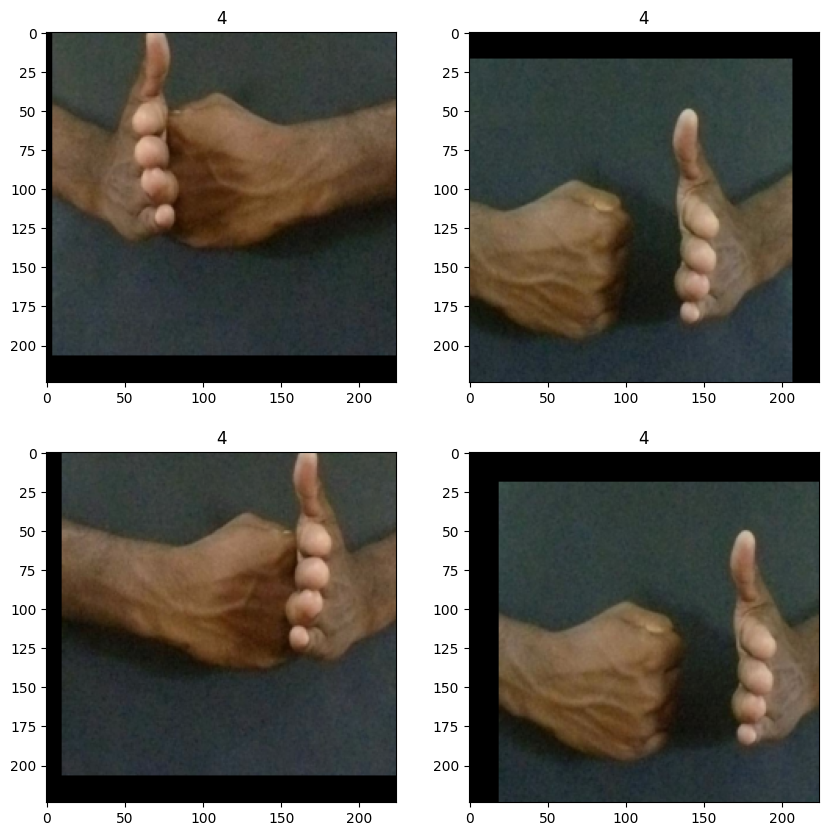

In [103]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

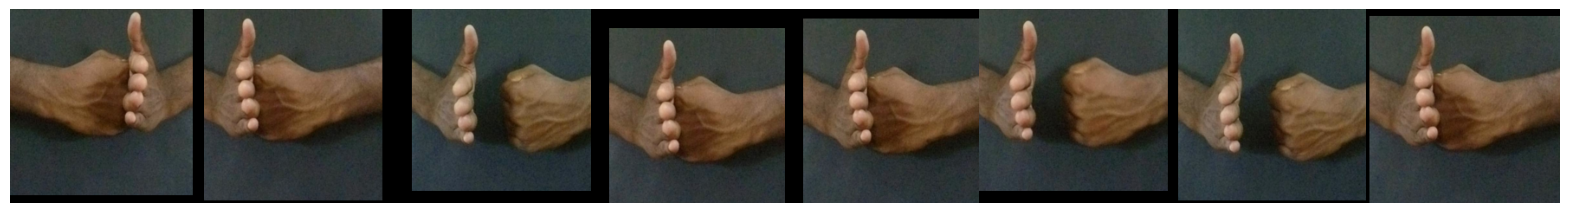

In [116]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for ii,img in enumerate(imgs[::2]):
    plt.subplot(1,8,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.axis("off")

In [117]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ]) 
test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)
print(len(test_ds))

42


In [118]:
imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

pain


(torch.Size([16, 3, 224, 224]), 3, tensor(-1.8097), tensor(1.7337))

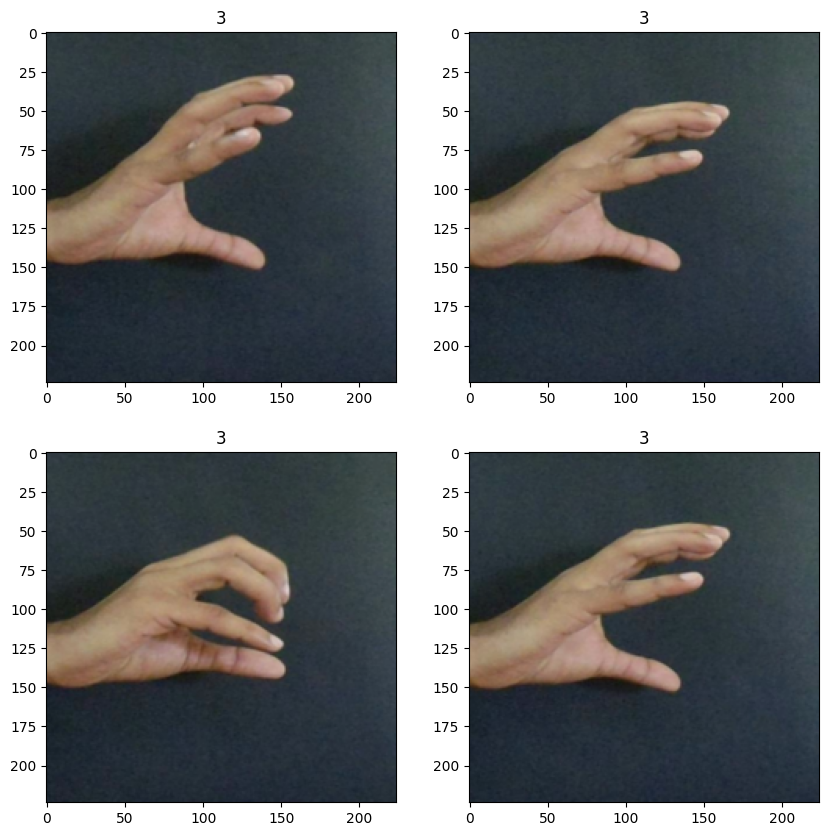

In [120]:
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

### Defining Dataloader

In [121]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor
    

batch_size = 1
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size,
                         shuffle=False, collate_fn= collate_fn_rnn)  
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size, 
                          shuffle=True, collate_fn= collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                         shuffle=False, collate_fn= collate_fn_r3d_18)    

In [122]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

lose
torch.Size([1, 16, 3, 224, 224]) torch.Size([1])


In [123]:
for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

hot
call
torch.Size([2, 16, 3, 224, 224]) torch.Size([2])
